In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df = pd.read_csv('drive/MyDrive/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,17.481333,17.533333,17.188000,17.276667,17.276667,39163500
1,2015-07-13,17.483334,17.503332,17.070000,17.477333,17.477333,44404500
2,2015-07-14,17.473333,17.732668,17.367332,17.709999,17.709999,28614000
3,2015-07-15,17.782667,17.832666,17.472000,17.542667,17.542667,30324000
4,2015-07-16,17.614668,17.813334,17.544001,17.778667,17.778667,24240000


In [2]:
df.shape

(1259, 7)

In [3]:
#Open Column: 주식 시작가
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values
print(training_set.shape, test_set.shape)

(800, 1) (459, 1)


In [5]:
#training set 표준화
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled[:5])

[[0.49064941]
 [0.49077224]
 [0.49015836]
 [0.509146  ]
 [0.49883383]]


In [20]:
X_train = []
y_train = []

#60일치 데이터를 보고 다음 날의 주식 시작가 예측
for i in range(60, 800):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

(740, 60, 1) (740,)


In [8]:
from re import X
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

In [15]:
#테스트 데이터 준비

dataset_total = df.iloc[:, 1:2]
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total) - len(test_set) - 60 : ].values #dataset_total[740:]
inputs = inputs.reshape(-1,1)
print(inputs.shape)

(1259, 1)
(519, 1)


In [27]:
X_test = []
for i in range(60, 519):
  X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(459, 60, 1)

In [35]:
predicted_stock_price_scaled = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled) #표준화 거꾸로
print(predicted_stock_price_sclaed[:5])
print()
print(predicted_stock_price[:5])

15/15 [==============================] - 0s 6ms/step
[[3.4069695]
 [3.4070952]
 [3.4076035]
 [3.4074352]
 [3.407548 ]]

[[64.99207 ]
 [64.994125]
 [65.0024  ]
 [64.999664]
 [65.001495]]


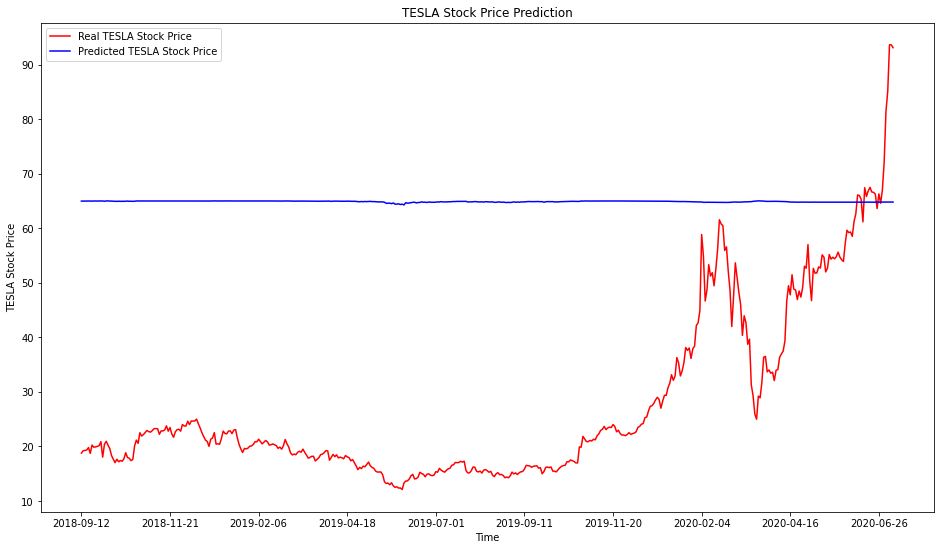

In [40]:
plt.figure(figsize=(16,9))
plt.plot(df.loc[800:, 'Date'], test_set, color='red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'], predicted_stock_price, color='blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()